In [1]:
import os
import numpy as np
import tensorflow as tf

from keras import backend as K

import scipy
import time
import imageio
import scipy.misc
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
## Allow Growth

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

### Variable

In [3]:
# Variable ti pass into model
ss_patch_size = 3
ss_stride = 1
vgg_path = 'WCT/vgg_normalised.t7'
style_size = 512
adain = False
keep_colors = False
content_path = 'data/test/' 
style_path = 'data/test_style/'
out_path = 'data/output/'
train_content_path = 'data/train/content'
train_style_path = 'data/train/style'
passes = 1
concat = True
alpha = 1
device = '/gpu:0'
count = 0
content_size=512
style_size=400
crop_size=0
checkpoints = ['WCT/relu5_1','WCT/relu4_1','WCT/relu3_1','WCT/relu2_1','WCT/relu1_1']
relu_targets = ['relu5_1','relu4_1','relu3_1','relu2_1','relu1_1']
swap5 = False
ss_alpha = 0.6
adain = False
save = True

### Coral

In [4]:
### NumPy implementation

def matSqrt_numpy(x):
    U,D,V = np.linalg.svd(x)
    result = U.dot(np.diag(np.sqrt(D))).dot(V.T)
    return result

def coral_numpy(source, target):
    n_channels = source.shape[-1]

    source = np.moveaxis(source, -1, 0)  # HxWxC -> CxHxW
    target = np.moveaxis(target, -1, 0)  # HxWxC -> CxHxW

    source_flatten = source.reshape(n_channels, source.shape[1]*source.shape[2])
    target_flatten = target.reshape(n_channels, target.shape[1]*target.shape[2])

    source_flatten_mean = source_flatten.mean(axis=1, keepdims=True)
    source_flatten_std = source_flatten.std(axis=1, keepdims=True)
    source_flatten_norm = (source_flatten - source_flatten_mean) / source_flatten_std

    target_flatten_mean = target_flatten.mean(axis=1, keepdims=True)
    target_flatten_std = target_flatten.std(axis=1, keepdims=True)
    target_flatten_norm = (target_flatten - target_flatten_mean) / target_flatten_std

    source_flatten_cov_eye = source_flatten_norm.dot(source_flatten_norm.T) + np.eye(n_channels)
    target_flatten_cov_eye = target_flatten_norm.dot(target_flatten_norm.T) + np.eye(n_channels)

    source_flatten_norm_transfer = matSqrt_numpy(target_flatten_cov_eye).dot(np.linalg.inv(matSqrt_numpy(source_flatten_cov_eye))).dot(source_flatten_norm)
    source_flatten_transfer = source_flatten_norm_transfer * target_flatten_std + target_flatten_mean

    coraled = source_flatten_transfer.reshape(source.shape)
    coraled = np.moveaxis(coraled, 0, -1)  # CxHxW -> HxWxC

    return coraled

### Utils

In [5]:
def save_img(out_path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(out_path, img)

In [6]:
def get_images_files(img_dir):
    paths = []
    if(os.path.isdir(content_path)):
        files = os.listdir(img_dir)
        for x in files:
            if x.lower().endswith(('.png', '.jpg', '.jpeg')):
                paths.append(os.path.join(img_dir, x))
    else:
        paths.appends(img_dir)
    return paths

In [7]:
def get_img(src):
    img = imageio.imread(src, pilmode='RGB')
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        img = np.dstack((img,img,img))
    return img

In [8]:
def center_crop(img, size=256):
    height, width = img.shape[0], img.shape[1]

    if height < size or width < size:  # Upscale to size if one side is too small
        img = resize_to(img, resize=size)
        height, width = img.shape[0], img.shape[1]

    h_off = (height - size) // 2
    w_off = (width - size) // 2
    return img[h_off:h_off+size,w_off:w_off+size]

In [9]:
def center_crop_to(img, H_target, W_target):
    '''Center crop a rectangle of given dimensions and resize if necessary'''
    height, width = img.shape[0], img.shape[1]

    if height < H_target or width < W_target:
        H_rat, W_rat = H_target / height, W_target / width
        rat = max(H_rat, W_rat)

        img = scipy.misc.imresize(img, rat, interp='bilinear')
        height, width = img.shape[0], img.shape[1]

    h_off = (height - H_target) // 2
    w_off = (width - W_target) // 2
    return img[h_off:h_off+H_target,w_off:w_off+W_target]

In [10]:
def resize_to(img, resize=512):
    '''Resize short side to target size and preserve aspect ratio'''
    height, width = img.shape[0], img.shape[1]
    if height < width:
        ratio = height / resize
        long_side = round(width / ratio)
        resize_shape = (resize, long_side, 3)
    else:
        ratio = width / resize
        long_side = round(height / ratio)
        resize_shape = (long_side, resize, 3)
    
    return scipy.misc.imresize(img, resize_shape, interp='bilinear')

In [11]:
def get_img_crop(src, resize=512, crop=256):
    '''Get & resize image and center crop'''
    img = get_img(src)
    img = resize_to(img, resize)
    return center_crop(img, crop)

In [12]:
def get_img_random_crop(src, resize=512, crop=256):
    '''Get & resize image and random crop'''
    img = get_img(src)
    img = resize_to(img, resize=resize)
    
    offset_h = random.randint(0, (img.shape[0]-crop))
    offset_w = random.randint(0, (img.shape[1]-crop))
    
    img = img[offset_h:offset_h+crop, offset_w:offset_w+crop, :]

    return img

In [13]:
def preserve_colors_np(style_rgb, content_rgb):
    coraled = coral_numpy(style_rgb/255., content_rgb/255.)
    coraled = np.uint8(np.clip(coraled, 0, 1) * 255.)
    return coraled

In [14]:
def swap_filter_fit(H, W, patch_size, stride, n_pools=4):
    '''Style swap may not output same size encoding if filter size > 1, calculate a new size to avoid this'''
    # Calculate size of encodings after max pooling n_pools times
    pool_out_size = lambda x: (x + 2 - 1) // 2    
    H_pool_out, W_pool_out = H, W
    for _ in range(n_pools):
        H_pool_out, W_pool_out = pool_out_size(H_pool_out), pool_out_size(W_pool_out)
    
    # Size of encoding after applying conv to determine nearest neighbor patches
    H_conv_out = (H_pool_out - patch_size) // stride + 1
    W_conv_out = (W_pool_out - patch_size) // stride + 1

    # Size after transposed conv
    H_deconv_out = (H_conv_out - 1) * stride + patch_size
    W_deconv_out = (W_conv_out - 1) * stride + patch_size

    # Stylized output size after decoding
    H_out = H_deconv_out * 2**n_pools
    W_out = W_deconv_out * 2**n_pools

    # Image will need to be resized/cropped if pooled encoding does not match style-swap encoding in either dim
    should_refit = (H_pool_out != H_deconv_out) or (W_pool_out != W_deconv_out)

    return should_refit, H_out, W_out

### Get Files

In [15]:
## Get Content File
content_files = get_images_files(content_path)

In [16]:
## Get Style File
style_files = get_images_files(style_path)

### Make Output Dir

In [17]:
os.makedirs(out_path, exist_ok=True)

### Torchfile - From torchfile.py ( For reading t7 file )

In [18]:
import struct
from array import array
from collections import namedtuple
import sys

In [19]:
TYPE_NIL = 0
TYPE_NUMBER = 1
TYPE_STRING = 2
TYPE_TABLE = 3
TYPE_TORCH = 4
TYPE_BOOLEAN = 5
TYPE_FUNCTION = 6
TYPE_RECUR_FUNCTION = 8
LEGACY_TYPE_RECUR_FUNCTION = 7

LuaFunction = namedtuple('LuaFunction',
                         ['size', 'dumped', 'upvalues'])

In [20]:
class mycontainer():
    def __init__(self, val):
        self.val = val
    def __hash__(self):
        return id(self.val)
    def __eq__(self, other):
        return id(self.val) == id(other.val)
    def __ne__(self, other):
        return id(self.val) != id(other.val)

In [21]:
class hashable_uniq_dict(dict):
    """
    Subclass of dict with equality and hashing semantics changed:
    equality and hashing is purely by reference/instance, to match
    the behaviour of lua tables.

    Supports lua-style dot indexing.

    This way, dicts can be keys of other dicts.
    """

    def __iter__(self):
        return iter(self.keys())

    def __getitem__(self, k):
        for _k,v in self.items():
            if str(_k) == str(k):
                return v

    def __setitem__(self, k, v):
        dict.__setitem__(self, mycontainer(k), v)

    def items(self):
        return [(k.val, v) for k,v in dict.items(self)]

    def keys(self):
        return [k.val for k in dict.keys(self)]

    def values(self):
        return [v for v in dict.values(self)]

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return id(self) == id(other)

    def _disabled_binop(self, other):
        raise TypeError(
            'hashable_uniq_dict does not support these comparisons')
    __cmp__ = __ne__ = __le__ = __gt__ = __lt__ = _disabled_binop

In [22]:
class TorchObject(object):
    """
    Simple torch object, used by `add_trivial_class_reader`.
    Supports both forms of lua-style indexing, i.e. getattr and getitem.
    Use the `torch_typename` method to get the object's torch class name.

    Equality is by reference, as usual for lua (and the default for Python
    objects).
    """

    def __init__(self, typename, obj=None, version_number=0):
        self._typename = typename
        self._obj = obj
        self._version_number = version_number

    def __getattr__(self, k):
        if k in self._obj.keys():
            return self._obj[k]
        if isinstance(k, (str, bytes)):
            return self._obj[k.encode('utf8')]
    
    def __getitem__(self, k):
        if k in self._obj.keys():
            return self._obj[k]
        if isinstance(k, (str, bytes)):
            return self._obj[k.encode('utf8')]

    def torch_typename(self):
        return self._typename

    def __repr__(self):
        return "TorchObject(%s, %s)" % (self._typename, repr(self._obj))

    def __str__(self):
        return repr(self)

    def __dir__(self):
        keys = self._obj.keys()
        keys.append('torch_typename')
        return keys

In [23]:
type_handlers = {}

In [24]:
def register_handler(typename):
    def do_register(handler):
        type_handlers[typename] = handler
    return do_register

In [25]:
def add_tensor_reader(typename, dtype):
    def read_tensor_generic(reader, version):
        # https://github.com/torch/torch7/blob/1e86025/generic/Tensor.c#L1249
        ndim = reader.read_int()

        size = reader.read_long_array(ndim)
        stride = reader.read_long_array(ndim)
        storage_offset = reader.read_long() - 1  # 0-indexing
        # read storage:
        storage = reader.read_obj()

        if storage is None or ndim == 0 or len(size) == 0 or len(stride) == 0:
            # empty torch tensor
            return np.empty((0), dtype=dtype)

        # convert stride to numpy style (i.e. in bytes)
        stride = [storage.dtype.itemsize * x for x in stride]

        # create numpy array that indexes into the storage:
        return np.lib.stride_tricks.as_strided(
            storage[storage_offset:],
            shape=size,
            strides=stride)
    type_handlers[typename] = read_tensor_generic
add_tensor_reader(b'torch.ByteTensor', dtype=np.uint8)
add_tensor_reader(b'torch.CharTensor', dtype=np.int8)
add_tensor_reader(b'torch.ShortTensor', dtype=np.int16)
add_tensor_reader(b'torch.IntTensor', dtype=np.int32)
add_tensor_reader(b'torch.LongTensor', dtype=np.int64)
add_tensor_reader(b'torch.FloatTensor', dtype=np.float32)
add_tensor_reader(b'torch.DoubleTensor', dtype=np.float64)
add_tensor_reader(b'torch.CudaTensor', dtype=np.float32)
add_tensor_reader(b'torch.CudaByteTensor', dtype=np.uint8)
add_tensor_reader(b'torch.CudaCharTensor', dtype=np.int8)
add_tensor_reader(b'torch.CudaShortTensor', dtype=np.int16)
add_tensor_reader(b'torch.CudaIntTensor', dtype=np.int32)
add_tensor_reader(b'torch.CudaDoubleTensor', dtype=np.float64)

In [26]:
def add_storage_reader(typename, dtype):
    def read_storage(reader, version):
        # https://github.com/torch/torch7/blob/1e86025/generic/Storage.c#L237
        size = reader.read_long()
        return np.fromfile(reader.f, dtype=dtype, count=size)
    type_handlers[typename] = read_storage
add_storage_reader(b'torch.ByteStorage', dtype=np.uint8)
add_storage_reader(b'torch.CharStorage', dtype=np.int8)
add_storage_reader(b'torch.ShortStorage', dtype=np.int16)
add_storage_reader(b'torch.IntStorage', dtype=np.int32)
add_storage_reader(b'torch.LongStorage', dtype=np.int64)
add_storage_reader(b'torch.FloatStorage', dtype=np.float32)
add_storage_reader(b'torch.DoubleStorage', dtype=np.float64)
add_storage_reader(b'torch.CudaStorage', dtype=np.float32)
add_storage_reader(b'torch.CudaByteStorage', dtype=np.uint8)
add_storage_reader(b'torch.CudaCharStorage', dtype=np.int8)
add_storage_reader(b'torch.CudaShortStorage', dtype=np.int16)
add_storage_reader(b'torch.CudaIntStorage', dtype=np.int32)
add_storage_reader(b'torch.CudaDoubleStorage', dtype=np.float64)

In [27]:
def add_notimpl_reader(typename):
    def read_notimpl(reader, version):
        raise NotImplementedError('Reader not implemented for: ' + typename)
    type_handlers[typename] = read_notimpl
add_notimpl_reader(b'torch.HalfTensor')
add_notimpl_reader(b'torch.HalfStorage')
add_notimpl_reader(b'torch.CudaHalfTensor')
add_notimpl_reader(b'torch.CudaHalfStorage')

In [28]:
@register_handler(b'tds.Vec')
def tds_Vec_reader(reader, version):
    size = reader.read_int()
    obj = []
    _ = reader.read_obj()
    for i in range(size):
        e = reader.read_obj()
        obj.append(e)
    return obj

In [29]:
@register_handler(b'tds.Hash')
def tds_Hash_reader(reader, version):
    size = reader.read_int()
    obj = hashable_uniq_dict()
    _ = reader.read_obj()
    for i in range(size):
        k = reader.read_obj()
        v = reader.read_obj()
        obj[k] = v
    return obj

In [30]:
class T7ReaderException(Exception):
    pass

In [31]:
class T7Reader:

    def __init__(self,
                 fileobj,
                 use_list_heuristic=True,
                 use_int_heuristic=True,
                 utf8_decode_strings=False,
                 force_deserialize_classes=None,
                 force_8bytes_long=False):
        """
        Params:
        * `fileobj`: file object to read from, must be an actual file object
                    as it will be read by `array`, `struct`, and `numpy`. Since
                    it is only read sequentially, certain objects like pipes or
                    `sys.stdin` should work as well (untested).
        * `use_list_heuristic`: automatically turn tables with only consecutive
                                positive integral indices into lists
                                (default True)
        * `use_int_heuristic`: cast all whole floats into ints (default True)
        * `utf8_decode_strings`: decode all strings as UTF8. By default they
                                remain as byte strings. Version strings always
                                are byte strings, but this setting affects
                                class names. (default False)
        * `force_deserialize_classes`: deprecated.
        """
        self.f = fileobj
        self.objects = {}  # read objects so far

        if force_deserialize_classes is not None:
            raise DeprecationWarning(
                'force_deserialize_classes is now always '
                'forced to be true, so no longer required')
        self.use_list_heuristic = use_list_heuristic
        self.use_int_heuristic = use_int_heuristic
        self.utf8_decode_strings = utf8_decode_strings
        self.force_8bytes_long = force_8bytes_long

    def _read(self, fmt):
        sz = struct.calcsize(fmt)
        return struct.unpack(fmt, self.f.read(sz))

    def read_boolean(self):
        return self.read_int() == 1

    def read_int(self):
        return self._read('i')[0]

    def read_long(self):
        if self.force_8bytes_long:
            return self._read('q')[0]
        else:
            return self._read('l')[0]

    def read_long_array(self, n):
        if self.force_8bytes_long:
            lst = []
            for i in range(n):
                lst.append(self.read_long())
            return lst
        else:
            arr = array('l')
            arr.fromfile(self.f, n)
            return arr.tolist()

    def read_float(self):
        return self._read('f')[0]

    def read_double(self):
        return self._read('d')[0]

    def read_string(self, disable_utf8=False):
        size = self.read_int()
        s = self.f.read(size)
        if disable_utf8 or not self.utf8_decode_strings:
            return s
        return s.decode('utf8')

    def read_obj(self):
        typeidx = self.read_int()

        if typeidx == TYPE_NIL:
            return None

        elif typeidx == TYPE_NUMBER:
            x = self.read_double()
            # Extra checking for integral numbers:
            if self.use_int_heuristic and x.is_integer():
                return int(x)
            return x

        elif typeidx == TYPE_BOOLEAN:
            return self.read_boolean()

        elif typeidx == TYPE_STRING:
            return self.read_string()

        elif (typeidx == TYPE_TABLE or typeidx == TYPE_TORCH or
                typeidx == TYPE_FUNCTION or typeidx == TYPE_RECUR_FUNCTION or
                typeidx == LEGACY_TYPE_RECUR_FUNCTION):
            # read the object reference index
            index = self.read_int()

            # check it is loaded already
            if index in self.objects:
                return self.objects[index]

            # otherwise read it
            if (typeidx == TYPE_FUNCTION or typeidx == TYPE_RECUR_FUNCTION or
                    typeidx == LEGACY_TYPE_RECUR_FUNCTION):
                size = self.read_int()
                dumped = self.f.read(size)
                upvalues = self.read_obj()
                obj = LuaFunction(size, dumped, upvalues)
                self.objects[index] = obj
                return obj

            elif typeidx == TYPE_TORCH:
                version = self.read_string(disable_utf8=True)
                if version.startswith(b'V '):
                    version_number = int(float(version.partition(b' ')[2]))
                    class_name = self.read_string(disable_utf8=True)
                else:
                    class_name = version
                    # created before existence of versioning
                    version_number = 0
                if class_name in type_handlers:
                    # TODO: can custom readers ever be self-referential?
                    self.objects[index] = None  # FIXME: if self-referential
                    obj = type_handlers[class_name](self, version)
                    self.objects[index] = obj
                else:
                    # This must be performed in two steps to allow objects
                    # to be a property of themselves.
                    obj = TorchObject(
                        class_name, version_number=version_number)
                    self.objects[index] = obj
                    # After self.objects is populated, it's safe to read in
                    # case self-referential
                    obj._obj = self.read_obj()
                return obj

            else:  # it is a table: returns a custom dict or a list
                size = self.read_int()
                # custom hashable dict, so that it can be a key, see above
                obj = hashable_uniq_dict()
                # For checking if keys are consecutive and positive ints;
                # if so, returns a list with indices converted to 0-indices.
                key_sum = 0
                keys_natural = True
                # bugfix: obj must be registered before reading keys and vals
                self.objects[index] = obj

                for _ in range(size):
                    k = self.read_obj()
                    v = self.read_obj()
                    obj[k] = v

                    if self.use_list_heuristic:
                        if not isinstance(k, int) or k <= 0:
                            keys_natural = False
                        elif isinstance(k, int):
                            key_sum += k

                if self.use_list_heuristic:
                    # n(n+1)/2 = sum <=> consecutive and natural numbers
                    n = len(obj)
                    if keys_natural and n * (n + 1) == 2 * key_sum:
                        lst = []
                        for i in range(len(obj)):
                            elem = obj[i + 1]
                            # In case it is self-referential. This is not
                            # needed in lua torch since the tables are never
                            # modified as they are here.
                            if elem == obj:
                                elem = lst
                            lst.append(elem)
                        self.objects[index] = obj = lst

                return obj

        else:
            raise T7ReaderException(
                "unknown object type / typeidx: {}".format(typeidx))

In [32]:
def load(filename, **kwargs):
    """
    Loads the given t7 file using default settings; kwargs are forwarded
    to `T7Reader`.
    """
    with open(filename, 'rb') as f:
        reader = T7Reader(f, **kwargs)
        return reader.read_obj()

### Layer & Operation

In [33]:
from keras.layers import Conv2D, Lambda
from tensorflow.python.layers import utils
# from numba import jit

In [34]:
def pad_reflect(x, padding=1):
    return tf.pad(
      x, [[0, 0], [padding, padding], [padding, padding], [0, 0]],
      mode='REFLECT')

In [35]:
def Conv2DReflect(lambda_name, *args, **kwargs):
    '''Wrap Keras Conv2D with reflect padding'''
    return Lambda(lambda x: Conv2D(*args, **kwargs)(pad_reflect(x)), name=lambda_name)

In [36]:
### Whiten-Color Transform ops ###

def wct_tf(content, style, alpha, eps=1e-8):
    '''TensorFlow version of Whiten-Color Transform
       Assume that content/style encodings have shape 1xHxWxC

       See p.4 of the Universal Style Transfer paper for corresponding equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # Remove batch dim and reorder to CxHxW
    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(tf.shape(content_t))
    Cs, Hs, Ws = tf.unstack(tf.shape(style_t))

    # CxHxW -> CxH*W
    content_flat = tf.reshape(content_t, (Cc, Hc*Wc))
    style_flat = tf.reshape(style_t, (Cs, Hs*Ws))

    # Content covariance
    mc = tf.reduce_mean(content_flat, axis=1, keep_dims=True)
    fc = content_flat - mc
    fcfc = tf.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc*Wc, tf.float32) - 1.) + tf.eye(Cc)*eps

    # Style covariance
    ms = tf.reduce_mean(style_flat, axis=1, keep_dims=True)
    fs = style_flat - ms
    fsfs = tf.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs*Ws, tf.float32) - 1.) + tf.eye(Cs)*eps

    # tf.svd is slower on GPU, see https://github.com/tensorflow/tensorflow/issues/13603
    with tf.device('/cpu:0'):  
        Sc, Uc, _ = tf.svd(fcfc)
        Ss, Us, _ = tf.svd(fsfs)

    ## Uncomment to perform SVD for content/style with np in one call
    ## This is slower than CPU tf.svd but won't segfault for ill-conditioned matrices
    # @jit
    # def np_svd(content, style):
    #     '''tf.py_func helper to run SVD with NumPy for content/style cov tensors'''
    #     Uc, Sc, _ = np.linalg.svd(content)
    #     Us, Ss, _ = np.linalg.svd(style)
    #     return Uc, Sc, Us, Ss
    # Uc, Sc, Us, Ss = tf.py_func(np_svd, [fcfc, fsfs], [tf.float32, tf.float32, tf.float32, tf.float32])

    # Filter small singular values
    k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.int32))
    k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.int32))

    # Whiten content feature
    Dc = tf.diag(tf.pow(Sc[:k_c], -0.5))
    fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:,:k_c], Dc), Uc[:,:k_c], transpose_b=True), fc)

    # Color content with style
    Ds = tf.diag(tf.pow(Ss[:k_s], 0.5))
    fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds), Us[:,:k_s], transpose_b=True), fc_hat)

    # Re-center with mean of style
    fcs_hat = fcs_hat + ms

    # Blend whiten-colored feature with original content feature
    blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)

    # CxH*W -> CxHxW
    blended = tf.reshape(blended, (Cc,Hc,Wc))
    # CxHxW -> 1xHxWxC
    blended = tf.expand_dims(tf.transpose(blended, (1,2,0)), 0)

    return blended

In [37]:
def wct_np(content, style, alpha=0.6, eps=1e-5):
    '''Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''    
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc

    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    
    Ec, wc, _ = np.linalg.svd(fcfc)

    k_c = (wc > 1e-5).sum()

    Dc = np.diag((wc[:k_c]+eps)**-0.5)

    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms

    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)

    Es, ws, _ = np.linalg.svd(fsfs)

    k_s = (ws > 1e-5).sum()
    
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))

    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)

    fcs_hat = fcs_hat + ms

    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)
    
    return np.float32(blended)

In [38]:
### Style-Swap WCT ###

def wct_style_swap(content, style, alpha, patch_size=3, stride=1, eps=1e-8):
    '''Modified Whiten-Color Transform that performs style swap on whitened content/style encodings before coloring
       Assume that content/style encodings have shape 1xHxWxC
    '''
    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(tf.shape(content_t))
    Cs, Hs, Ws = tf.unstack(tf.shape(style_t))

    # CxHxW -> CxH*W
    content_flat = tf.reshape(content_t, (Cc, Hc*Wc))
    style_flat = tf.reshape(style_t, (Cs, Hs*Ws))

    # Content covariance
    mc = tf.reduce_mean(content_flat, axis=1, keep_dims=True)
    fc = content_flat - mc
    fcfc = tf.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc*Wc, tf.float32) - 1.) + tf.eye(Cc)*eps

    # Style covariance
    ms = tf.reduce_mean(style_flat, axis=1, keep_dims=True)
    fs = style_flat - ms
    fsfs = tf.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs*Ws, tf.float32) - 1.) + tf.eye(Cs)*eps

    # tf.svd is slower on GPU, see https://github.com/tensorflow/tensorflow/issues/13603
    with tf.device('/cpu:0'):  
        Sc, Uc, _ = tf.svd(fcfc)
        Ss, Us, _ = tf.svd(fsfs)

    ## Uncomment to perform SVD for content/style with np in one call
    ## This is slower than CPU tf.svd but won't segfault for ill-conditioned matrices
    # @jit
    # def np_svd(content, style):
    #     '''tf.py_func helper to run SVD with NumPy for content/style cov tensors'''
    #     Uc, Sc, _ = np.linalg.svd(content)
    #     Us, Ss, _ = np.linalg.svd(style)
    #     return Uc, Sc, Us, Ss
    # Uc, Sc, Us, Ss = tf.py_func(np_svd, [fcfc, fsfs], [tf.float32, tf.float32, tf.float32, tf.float32])
    
    k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.int32))
    k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.int32))

    ### Whiten content
    Dc = tf.diag(tf.pow(Sc[:k_c], -0.5))

    fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:,:k_c], Dc), Uc[:,:k_c], transpose_b=True), fc)

    # Reshape before passing to style swap, CxH*W -> 1xHxWxC
    whiten_content = tf.expand_dims(tf.transpose(tf.reshape(fc_hat, [Cc,Hc,Wc]), [1,2,0]), 0)

    ### Whiten style before swapping
    Ds = tf.diag(tf.pow(Ss[:k_s], -0.5))
    whiten_style = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds), Us[:,:k_s], transpose_b=True), fs)
    # Reshape before passing to style swap, CxH*W -> 1xHxWxC
    whiten_style = tf.expand_dims(tf.transpose(tf.reshape(whiten_style, [Cs,Hs,Ws]), [1,2,0]), 0)

    ### Style swap whitened encodings
    ss_feature = style_swap(whiten_content, whiten_style, patch_size, stride)
    # HxWxC -> CxH*W
    ss_feature = tf.transpose(tf.reshape(ss_feature, [Hc*Wc,Cc]), [1,0])

    ### Color style-swapped encoding with style 
    Ds_sq = tf.diag(tf.pow(Ss[:k_s], 0.5))
    fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds_sq), Us[:,:k_s], transpose_b=True), ss_feature)
    fcs_hat = fcs_hat + ms

    ### Blend style-swapped & colored encoding with original content encoding
    blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)
    # CxH*W -> CxHxW
    blended = tf.reshape(blended, (Cc,Hc,Wc))
    # CxHxW -> 1xHxWxC
    blended = tf.expand_dims(tf.transpose(blended, (1,2,0)), 0)

    return blended

In [39]:
def style_swap(content, style, patch_size, stride):
    '''Efficiently swap content feature patches with nearest-neighbor style patches
       Original paper: https://arxiv.org/abs/1612.04337
       Adapted from: https://github.com/rtqichen/style-swap/blob/master/lib/NonparametricPatchAutoencoderFactory.lua
    '''
    nC = tf.shape(style)[-1]  # Num channels of input content feature and style-swapped output

    ### Extract patches from style image that will be used for conv/deconv layers
    style_patches = tf.extract_image_patches(style, [1,patch_size,patch_size,1], [1,stride,stride,1], [1,1,1,1], 'VALID')
    before_reshape = tf.shape(style_patches)  # NxRowsxColsxPatch_size*Patch_size*nC
    style_patches = tf.reshape(style_patches, [before_reshape[1]*before_reshape[2],patch_size,patch_size,nC])
    style_patches = tf.transpose(style_patches, [1,2,3,0])  # Patch_sizexPatch_sizexIn_CxOut_c

    # Normalize each style patch
    style_patches_norm = tf.nn.l2_normalize(style_patches, dim=3)

    # Compute cross-correlation/nearest neighbors of patches by using style patches as conv filters
    ss_enc = tf.nn.conv2d(content,
                          style_patches_norm,
                          [1,stride,stride,1],
                          'VALID')

    # For each spatial position find index of max along channel/patch dim  
    ss_argmax = tf.argmax(ss_enc, axis=3)
    encC = tf.shape(ss_enc)[-1]  # Num channels in intermediate conv output, same as # of patches
    
    # One-hot encode argmax with same size as ss_enc, with 1's in max channel idx for each spatial pos
    ss_oh = tf.one_hot(ss_argmax, encC, 1., 0., 3)

    # Calc size of transposed conv out
    deconv_out_H = utils.deconv_output_length(tf.shape(ss_oh)[1], patch_size, 'valid', stride)
    deconv_out_W = utils.deconv_output_length(tf.shape(ss_oh)[2], patch_size, 'valid', stride)
    deconv_out_shape = tf.stack([1,deconv_out_H,deconv_out_W,nC])

    # Deconv back to original content size with highest matching (unnormalized) style patch swapped in for each content patch
    ss_dec = tf.nn.conv2d_transpose(ss_oh,
                                    style_patches,
                                    deconv_out_shape,
                                    [1,stride,stride,1],
                                    'VALID')

    ### Interpolate to average overlapping patch locations
    ss_oh_sum = tf.reduce_sum(ss_oh, axis=3, keep_dims=True)

    filter_ones = tf.ones([patch_size,patch_size,1,1], dtype=tf.float32)
    
    deconv_out_shape = tf.stack([1,deconv_out_H,deconv_out_W,1])  # Same spatial size as ss_dec with 1 channel

    counting = tf.nn.conv2d_transpose(ss_oh_sum,
                                         filter_ones,
                                         deconv_out_shape,
                                         [1,stride,stride,1],
                                         'VALID')

    counting = tf.tile(counting, [1,1,1,nC])  # Repeat along channel dim to make same size as ss_dec

    interpolated_dec = tf.divide(ss_dec, counting)

    return interpolated_dec

In [40]:
### Adaptive Instance Normalization ###

def adain(content_features, style_features, alpha, epsilon=1e-5):
    '''
    Borrowed from https://github.com/jonrei/tf-AdaIN
    Normalizes the `content_features` with scaling and offset from `style_features`.
    See "5. Adaptive Instance Normalization" in https://arxiv.org/abs/1703.06868 for details.
    '''
    style_mean, style_variance = tf.nn.moments(style_features, [1,2], keep_dims=True)
    content_mean, content_variance = tf.nn.moments(content_features, [1,2], keep_dims=True)
    normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                            content_variance, style_mean, 
                                                            tf.sqrt(style_variance), epsilon)
    normalized_content_features = alpha * normalized_content_features + (1 - alpha) * content_features
    return normalized_content_features

In [41]:
### Misc ###

def torch_decay(learning_rate, global_step, decay_rate, name=None):
    '''Adapted from https://github.com/torch/optim/blob/master/adam.lua'''
    if global_step is None:
        raise ValueError("global_step is required for exponential_decay.")
    with tf.name_scope(name, "ExponentialDecay", [learning_rate, global_step, decay_rate]) as name:
        learning_rate = tf.convert_to_tensor(learning_rate, name="learning_rate")
        dtype = learning_rate.dtype
        global_step = tf.cast(global_step, dtype)
        decay_rate = tf.cast(decay_rate, dtype)

        # local clr = lr / (1 + state.t*lrd)
        return learning_rate / (1 + global_step*decay_rate)

### VGG from T7

In [42]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Activation, Lambda, MaxPooling2D

In [43]:
def vgg_from_t7(t7_file, target_layer=None):
    '''Extract VGG layers from a Torch .t7 model into a Keras model
       e.g. vgg = vgg_from_t7('vgg_normalised.t7', target_layer='relu4_1')
       Adapted from https://github.com/jonrei/tf-AdaIN/blob/master/AdaIN.py
       Converted caffe->t7 from https://github.com/xunhuang1995/AdaIN-style
    '''
    t7 = load(t7_file, force_8bytes_long=True)
    
    inp = Input(shape=(None, None, 3), name='vgg_input')

    x = inp
    
    for idx,module in enumerate(t7.modules):
        name = module.name.decode() if module.name is not None else None
        
        if idx == 0:
            name = 'preprocess'  # VGG 1st layer preprocesses with a 1x1 conv to multiply by 255 and subtract BGR mean as bias

        if module._typename == b'nn.SpatialReflectionPadding':
            x = Lambda(pad_reflect)(x)            
        elif module._typename == b'nn.SpatialConvolution':
            filters = module.nOutputPlane
            kernel_size = module.kH
            weight = module.weight.transpose([2,3,1,0])
            bias = module.bias
            x = Conv2D(filters, kernel_size, padding='valid', activation=None, name=name,
                        kernel_initializer=lambda shape: K.constant(weight, shape=shape),
                        bias_initializer=lambda shape: K.constant(bias, shape=shape),
                        trainable=False)(x)
        elif module._typename == b'nn.ReLU':
            x = Activation('relu', name=name)(x)
        elif module._typename == b'nn.SpatialMaxPooling':
            x = MaxPooling2D(padding='same', name=name)(x)
        # elif module._typename == b'nn.SpatialUpSamplingNearest': # Not needed for VGG
        #     x = Upsampling2D(name=name)(x)
        else:
            raise NotImplementedError(module._typename)

        if name == target_layer:
            # print("Reached target layer", target_layer)
            break
    
    # Hook it up
    model = Model(inputs=inp, outputs=x)

    return model

### WCT Model

In [44]:
### Helpers ###

mse = tf.losses.mean_squared_error

clip = lambda x: tf.clip_by_value(x, 0, 1)

EncoderDecoder = namedtuple('EncoderDecoder', 
                            'content_input content_encoder_model content_encoded \
                             style_encoded \
                             decoder_input, decoder_model decoded decoded_encoded \
                             pixel_loss feature_loss tv_loss total_loss \
                             train_op learning_rate global_step \
                             summary_op')

In [45]:
### WCT Model Graph ###

class WCTModel(object):
    '''Model graph for Universal Style Transfer via Feature Transforms from https://arxiv.org/abs/1705.08086'''

    def __init__(self, mode='train', relu_targets=['relu5_1','relu4_1','relu3_1','relu2_1','relu1_1'], vgg_path=None,  
                 *args, **kwargs):
        '''
            Args:
                mode: 'train' or 'test'. If 'train' then training & summary ops will be added to the graph
                relu_targets: List of relu target layers corresponding to decoder checkpoints
                vgg_path: Normalised VGG19 .t7 path
        '''
        self.mode = mode

        self.style_input = tf.placeholder_with_default(tf.constant([[[[0.,0.,0.]]]]), shape=(None, None, None, 3), name='style_img')

        self.alpha = tf.placeholder_with_default(1., shape=[], name='alpha')
        
        # Style swap settings
        self.swap5 = tf.placeholder_with_default(tf.constant(False), shape=[])
        self.ss_alpha = tf.placeholder_with_default(.7, shape=[], name='ss_alpha')

        # Flag to use AdaIN instead of WCT
        self.use_adain = tf.placeholder_with_default(tf.constant(False), shape=[])
        
        self.encoder_decoders = []
        
        ### Build the graph ###
        
        # Load shared VGG model up to deepest target layer
        with tf.name_scope('vgg_encoder'):
            deepest_target = sorted(relu_targets)[-1]
            print('Loading VGG up to layer',deepest_target)
            self.vgg_model = vgg_from_t7(vgg_path, target_layer=deepest_target)
            print(self.vgg_model.summary())

        if self.mode == 'train':
            style_encodings = [None]  # Style encoding is not needed for train stage
        else:
            # Build model to extract intermediate relu layers for style img to be used in multi-level pipeline
            with tf.name_scope('style_encoder'):
                style_encoding_layers = [self.vgg_model.get_layer(relu).output for relu in relu_targets]
                style_encoder_model = Model(inputs=self.vgg_model.input, outputs=style_encoding_layers)
                style_encodings = style_encoder_model(self.style_input)

            if len(relu_targets) == 1:
                style_encodings = [style_encodings]

        # Build enc/decs for each target relu and hook the out of each decoder up to subsequent encoder input
        for i, (relu, style_encoded) in enumerate(zip(relu_targets, style_encodings)):
            print('Building encoder/decoder for relu target',relu)
            
            if i == 0:
                # Input tensor will be a placeholder for the first encoder/decoder
                input_tensor = None
            else:
                # Input to intermediate levels is the output from previous decoder
                input_tensor = clip(self.encoder_decoders[-1].decoded)
            
            enc_dec = self.build_model(relu, input_tensor=input_tensor, style_encoded_tensor=style_encoded, **kwargs)
        
            self.encoder_decoders.append(enc_dec)

        # Hooks for placeholder input for first encoder and final output from last decoder
        self.content_input  = self.encoder_decoders[0].content_input
        self.decoded_output = self.encoder_decoders[-1].decoded
        
    def build_model(self, 
                    relu_target,
                    input_tensor,
                    style_encoded_tensor=None,
                    batch_size=8,
                    feature_weight=1,
                    pixel_weight=1,
                    tv_weight=0,
                    learning_rate=1e-4,
                    lr_decay=5e-5,
                    ss_patch_size=3,
                    ss_stride=1):
        '''Build the EncoderDecoder architecture for a given relu layer.

            Args:
                relu_target: Layer of VGG to decode from
                input_tensor: If None then a placeholder will be created, else use this tensor as the input to the encoder
                style_encoded_tensor: Tensor for style image features at the same relu layer. Used only at test time.
                batch_size: Batch size for training
                feature_weight: Float weight for feature reconstruction loss
                pixel_weight: Float weight for pixel reconstruction loss
                tv_weight: Float weight for total variation loss
                learning_rate: Float LR
                lr_decay: Float linear decay for training
            Returns:
                EncoderDecoder namedtuple with input/encoding/output tensors and ops for training.
        '''
        with tf.name_scope('encoder_decoder_'+relu_target):

            ### Build encoder for reluX_1
            with tf.name_scope('content_encoder_'+relu_target):
                if input_tensor is None:  
                    # This is the first level encoder that takes original content imgs
                    content_imgs = tf.placeholder_with_default(tf.constant([[[[0.,0.,0.]]]]), shape=(None, None, None, 3), name='content_imgs')
                else:                     
                    # This is an intermediate-level encoder that takes output tensor from previous level as input
                    content_imgs = input_tensor  

                # Build content layer encoding model
                content_layer = self.vgg_model.get_layer(relu_target).output
                content_encoder_model = Model(inputs=self.vgg_model.input, outputs=content_layer)

                # Setup content layer encodings for content images
                content_encoded = content_encoder_model(content_imgs)
 
            ### Build style encoder & WCT if test mode
            if self.mode != 'train':                
                with tf.name_scope('wct_'+relu_target):
                    if relu_target == 'relu5_1':
                        # Apply style swap on relu5_1 encodings if self.swap5 flag is set
                        # Use AdaIN as transfer op instead of WCT if self.use_adain is set
                        # Otherwise perform WCT
                        decoder_input = tf.case([(self.swap5, lambda: wct_style_swap(content_encoded,
                                                                                    style_encoded_tensor,
                                                                                    self.ss_alpha,
                                                                                    ss_patch_size, 
                                                                                    ss_stride)),
                                                (self.use_adain, lambda: adain(content_encoded, style_encoded_tensor, self.alpha))],
                                                default=lambda: wct_tf(content_encoded, style_encoded_tensor, self.alpha))
                    else:
                        decoder_input = tf.cond(self.use_adain, 
                                                lambda: adain(content_encoded, style_encoded_tensor, self.alpha),
                                                lambda: wct_tf(content_encoded, style_encoded_tensor, self.alpha))

                    
            else: # In train mode we're trying to reconstruct from the encoding, so pass along unchanged
                decoder_input = content_encoded

            ### Build decoder
            with tf.name_scope('decoder_'+relu_target):
                n_channels = content_encoded.get_shape()[-1].value
                decoder_model = self.build_decoder(input_shape=(None, None, n_channels), relu_target=relu_target)

                # Wrap the decoder_input tensor so that it has the proper shape for decoder_model
                decoder_input_wrapped = tf.placeholder_with_default(decoder_input, shape=[None,None,None,n_channels])

                # Reconstruct/decode from encoding
                decoded = decoder_model(Lambda(lambda x: x)(decoder_input_wrapped)) # Lambda converts TF tensor to Keras

            # Content layer encoding for stylized out
            decoded_encoded = content_encoder_model(decoded)

        if self.mode == 'train':  # Train & summary ops only needed for training phase
            ### Losses
            with tf.name_scope('losses_'+relu_target):
                # Feature loss between encodings of original & reconstructed
                feature_loss = feature_weight * mse(decoded_encoded, content_encoded)

                # Pixel reconstruction loss between decoded/reconstructed img and original
                pixel_loss = pixel_weight * mse(decoded, content_imgs)

                # Total Variation loss
                if tv_weight > 0:
                    tv_loss = tv_weight * tf.reduce_mean(tf.image.total_variation(decoded))
                else:
                    tv_loss = tf.constant(0.)

                total_loss = feature_loss + pixel_loss + tv_loss

            ### Training ops
            with tf.name_scope('train_'+relu_target):
                global_step = tf.Variable(0, name='global_step_train', trainable=False)
                # self.learning_rate = tf.train.exponential_decay(learning_rate, self.global_step, 100, 0.96, staircase=False)
                learning_rate = torch_decay(learning_rate, global_step, lr_decay)
                d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

                # Only train decoder vars, encoder is frozen
                d_vars = [var for var in tf.trainable_variables() if 'decoder_'+relu_target in var.name]

                train_op = d_optimizer.minimize(total_loss, var_list=d_vars, global_step=global_step)

            ### Loss & image summaries
            with tf.name_scope('summary_'+relu_target):
                feature_loss_summary = tf.summary.scalar('feature_loss', feature_loss)
                pixel_loss_summary = tf.summary.scalar('pixel_loss', pixel_loss)
                tv_loss_summary = tf.summary.scalar('tv_loss', tv_loss)
                total_loss_summary = tf.summary.scalar('total_loss', total_loss)

                content_imgs_summary = tf.summary.image('content_imgs', content_imgs)
                decoded_images_summary = tf.summary.image('decoded_images', clip(decoded))
                
                for var in d_vars:
                    tf.summary.histogram(var.op.name, var)

                summary_op = tf.summary.merge_all()
        else:
            # For inference set unnneeded ops to None
            pixel_loss, feature_loss, tv_loss, total_loss, train_op, global_step, learning_rate, summary_op = [None]*8

        # Put it all together
        encoder_decoder = EncoderDecoder(content_input=content_imgs, 
                                         content_encoder_model=content_encoder_model,
                                         content_encoded=content_encoded,
                                         style_encoded=style_encoded_tensor,
                                         decoder_input=decoder_input,
                                         decoder_model=decoder_model,
                                         decoded=decoded,
                                         decoded_encoded=decoded_encoded,
                                         pixel_loss=pixel_loss,
                                         feature_loss=feature_loss,
                                         tv_loss=tv_loss,
                                         total_loss=total_loss,
                                         train_op=train_op,
                                         global_step=global_step,
                                         learning_rate=learning_rate,
                                         summary_op=summary_op)
        
        return encoder_decoder

    def build_decoder(self, input_shape, relu_target): 
        '''Build the decoder architecture that reconstructs from a given VGG relu layer.

            Args:
                input_shape: Tuple of input tensor shape, needed for channel dimension
                relu_target: Layer of VGG to decode from
        '''
        decoder_num = dict(zip(['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'], range(1,6)))[relu_target]

        # Dict specifying the layers for each decoder level. relu5_1 is the deepest decoder and will contain all layers
        decoder_archs = {
            5: [ #    layer    filts      HxW  / InC->OutC                                     
                (Conv2DReflect, 512),  # 16x16 / 512->512
                (UpSampling2D,),       # 16x16 -> 32x32
                (Conv2DReflect, 512),  # 32x32 / 512->512
                (Conv2DReflect, 512),  # 32x32 / 512->512
                (Conv2DReflect, 512)], # 32x32 / 512->512
            4: [
                (Conv2DReflect, 256),  # 32x32 / 512->256
                (UpSampling2D,),       # 32x32 -> 64x64
                (Conv2DReflect, 256),  # 64x64 / 256->256
                (Conv2DReflect, 256),  # 64x64 / 256->256
                (Conv2DReflect, 256)], # 64x64 / 256->256
            3: [
                (Conv2DReflect, 128),  # 64x64 / 256->128
                (UpSampling2D,),       # 64x64 -> 128x128
                (Conv2DReflect, 128)], # 128x128 / 128->128
            2: [
                (Conv2DReflect, 64),   # 128x128 / 128->64
                (UpSampling2D,)],      # 128x128 -> 256x256
            1: [
                (Conv2DReflect, 64)]   # 256x256 / 64->64
        }

        code = Input(shape=input_shape, name='decoder_input_'+relu_target)
        x = code

        ### Work backwards from deepest decoder # and build layer by layer
        decoders = reversed(range(1, decoder_num+1))
        count = 0        
        for d in decoders:
            for layer_tup in decoder_archs[d]:
                # Unique layer names are needed to ensure var naming consistency with multiple decoders in graph
                layer_name = '{}_{}'.format(relu_target, count)

                if layer_tup[0] == Conv2DReflect:
                    x = Conv2DReflect(layer_name, filters=layer_tup[1], kernel_size=3, padding='valid', activation='relu', name=layer_name)(x)
                elif layer_tup[0] == UpSampling2D:
                    x = UpSampling2D(name=layer_name)(x)
                
                count += 1

        layer_name = '{}_{}'.format(relu_target, count) 
        output = Conv2DReflect(layer_name, filters=3, kernel_size=3, padding='valid', activation=None, name=layer_name)(x)  # 256x256 / 64->3
        
        decoder_model = Model(code, output, name='decoder_model_'+relu_target)
        
        print(decoder_model.summary())
        
        return decoder_model

### WCT Object

In [46]:
class WCT(object):
    '''Styilze images with trained WCT model'''

    def __init__(self, checkpoints, relu_targets, vgg_path, device='/gpu:0',
                 ss_patch_size=3, ss_stride=1): 
        '''
            Args:
                checkpoints: List of trained decoder model checkpoint dirs
                relu_targets: List of relu target layers corresponding to decoder checkpoints
                vgg_path: Normalised VGG19 .t7 path
                device: String for device ID to load model onto
        '''       
        self.ss_patch_size = ss_patch_size
        self.ss_stride = ss_stride

        graph = tf.get_default_graph()

        with graph.device(device):
            # Build the graph
            self.model = WCTModel(mode='test', relu_targets=relu_targets, vgg_path=vgg_path,
                                  ss_patch_size=self.ss_patch_size, ss_stride=self.ss_stride)
            
            self.content_input = self.model.content_input
            self.decoded_output = self.model.decoded_output
            # self.style_encoded = None

            config = tf.ConfigProto(allow_soft_placement=True)
            config.gpu_options.allow_growth = True
            self.sess = tf.Session(config=config)

            self.sess.run(tf.global_variables_initializer())

            # Load decoder vars one-by-one into the graph
            for relu_target, checkpoint_dir in zip(relu_targets, checkpoints):
                decoder_prefix = 'decoder_{}'.format(relu_target)
                relu_vars = [v for v in tf.trainable_variables() if decoder_prefix in v.name]

                saver = tf.train.Saver(var_list=relu_vars)
                
                ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('Restoring vars for {} from checkpoint {}'.format(relu_target, ckpt.model_checkpoint_path))
                    saver.restore(self.sess, ckpt.model_checkpoint_path)
                else:
                    raise Exception('No checkpoint found for target {} in dir {}'.format(relu_target, checkpoint_dir))

    @staticmethod
    def preprocess(image):
        if len(image.shape) == 3:  # Add batch dimension
            image = np.expand_dims(image, 0)
        return image / 255.        # Range [0,1]

    @staticmethod
    def postprocess(image):
        return np.uint8(np.clip(image, 0, 1) * 255)

    def predict(self, content, style, alpha=1, swap5=False, ss_alpha=1, adain=False):
        '''Stylize a single content/style pair.

           Args:
               content: Array for content image in [0,255]
               style: Array for style image in [0,255]
               alpha: Float blending value for WCT op in [0,1]
               swap5: If True perform style swap at layer relu5_1 instead of WCT
               ss_alpha: [0,1] Float blending value for style-swapped feature & content feature
               adain: Boolean indicating whether to use AdaIN transform instead of WCT
           Returns:
               Stylized image with pixels in [0,255]
        '''
        # If doing style swap and stride > 1 the content might need to be resized for the filter to fit
        if swap5 is True and self.ss_stride != 1:
            old_H, old_W = content.shape[:2]

            should_refit, H, W = swap_filter_fit(old_H, old_W, self.ss_patch_size, self.ss_stride)

            if should_refit:
                content = center_crop_to(content, H, W)

        # Make sure shape is correct and pixels are in [0,1]
        content = self.preprocess(content)
        style   = self.preprocess(style)

        s = time.time()
        stylized = self.sess.run(self.decoded_output, feed_dict={
                                                          self.content_input: content,
                                                          self.model.style_input: style,
                                                          self.model.alpha: alpha,
                                                          self.model.swap5: swap5,
                                                          self.model.ss_alpha: ss_alpha,
                                                          self.model.use_adain: adain})
        print("Stylized in:",time.time() - s)

        return self.postprocess(stylized[0])

### Run

In [47]:
# Load the WCT model
wct_model = WCT(checkpoints=checkpoints, 
                            relu_targets=relu_targets,
                            vgg_path=vgg_path, 
                            device=device,
                            ss_patch_size=ss_patch_size, 
                            ss_stride=ss_stride)

Loading VGG up to layer relu5_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_input (InputLayer)       (None, None, None, 3)     0         
_________________________________________________________________
preprocess (Conv2D)          (None, None, None, 3)     12        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 64)    1792      
_________________________________________________________________
relu1_1 (Activation)         (None, None, None, 64)    0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, None, 64)    0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, No

Building encoder/decoder for relu target relu4_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input_relu4_1 (Input (None, None, None, 512)   0         
_________________________________________________________________
relu4_1_0 (Lambda)           (None, None, None, 256)   0         
_________________________________________________________________
relu4_1_1 (UpSampling2D)     (None, None, None, 256)   0         
_________________________________________________________________
relu4_1_2 (Lambda)           (None, None, None, 256)   0         
_________________________________________________________________
relu4_1_3 (Lambda)           (None, None, None, 256)   0         
_________________________________________________________________
relu4_1_4 (Lambda)           (None, None, None, 256)   0         
_________________________________________________________________
relu4_1_5 (Lambda)         

/home/nvidia/dev/py3_keras/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


Stylized in: 14.534120082855225
0: Wrote stylized output image to data/output/1-PCvPN5wUo8vPzN_eX0mffg_style2.jpeg


/home/nvidia/dev/py3_keras/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/nvidia/dev/py3_keras/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


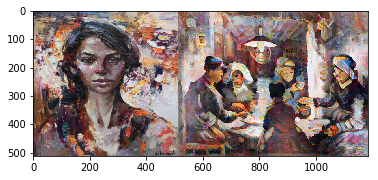

Stylized in: 8.088410139083862
1: Wrote stylized output image to data/output/input5_style2.jpg


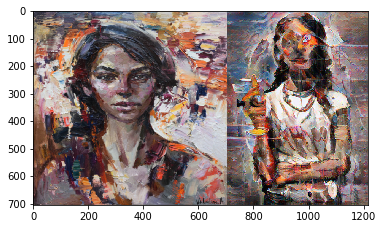

Finished stylizing 2 outputs in 24.37729811668396s


In [48]:
start = time.time()
count = 0

### Apply each style to each content image
for content_fullpath in content_files:
    content_prefix, content_ext = os.path.splitext(content_fullpath)
    content_prefix = os.path.basename(content_prefix)  # Extract filename prefix without ext

    content_img = get_img(content_fullpath)
    if content_size > 0:
        content_img = resize_to(content_img, content_size)

    for style_fullpath in style_files: 
        style_prefix, _ = os.path.splitext(style_fullpath)
        style_prefix = os.path.basename(style_prefix)  # Extract filename prefix without ext

        # style_img = get_img_crop(style_fullpath, resize=args.style_size, crop=args.crop_size)
        # style_img = resize_to(get_img(style_fullpath), content_img.shape[0])

        style_img = get_img(style_fullpath)

        if style_size > 0:
            style_img = resize_to(style_img, style_size)
        if crop_size > 0:
            style_img = center_crop(style_img, crop_size)

        if keep_colors:
            style_img = preserve_colors_np(style_img, content_img)

        # if args.noise:  # Generate textures from noise instead of images
        #     frame_resize = np.random.randint(0, 256, frame_resize.shape, np.uint8)
        #     frame_resize = gaussian_filter(frame_resize, sigma=0.5)

        # Run the frame through the style network
        stylized_rgb = wct_model.predict(content_img, style_img, alpha, swap5, ss_alpha, adain)

        if passes > 1:
            for _ in range(passes-1):
                stylized_rgb = wct_model.predict(stylized_rgb, style_img, alpha, swap5, ss_alpha, adain)

        # Stitch the style + stylized output together, but only if there's one style image
        if concat:
            # Resize style img to same height as frame
            style_img_resized = scipy.misc.imresize(style_img, (stylized_rgb.shape[0], stylized_rgb.shape[0]))
            # margin = np.ones((style_img_resized.shape[0], 10, 3)) * 255
            stylized_rgb = np.hstack([style_img_resized, stylized_rgb])

        # Format for out filename: {out_path}/{content_prefix}_{style_prefix}.{content_ext}
        out_f = os.path.join(out_path, '{}_{}{}'.format(content_prefix, style_prefix, content_ext))
        # out_f = f'{content_prefix}_{style_prefix}.{content_ext}'
        if save:
            save_img(out_f, stylized_rgb)
            print("{}: Wrote stylized output image to {}".format(count, out_f))

        count += 1
        plt.imshow(stylized_rgb)
        plt.show()

print("Finished stylizing {} outputs in {}s".format(count, time.time() - start))